### Topic: Correlation between Economics and Real Estate


<ul>
<li>College: Mt San Antonio College</li>
<li>Course: CISD41 Introduction to Data Science</li>
<li>by: Alec Phong and Jack Chen</li>
<br>
<br>


### Overview


<ol>
<li>Questions</li>
<li>Importing Data</li>
<li>Functions and Lambda</li>
<li>Cleaning Data</li>
<li>Organizing Data</li>
<li>Pivot tables</li>
<li>Data Visualization</li>
<li>Descriptive Statistics</li>
<ul><li>Mean, median, standard deviation, precentiles, boxplots</li></ul>
<li>Quantitative Data Exploratory</li>
<ul><li>Correlation, Coefficients, P-values</li></ul>
<li>Testing Hypothesis, ANOVA</li>
<ul><li>Chisquare, ANOVA, Normal-test, Z-test, Pearson Correlation</li></ul>
<li>Summary and Conclusion</li>
<li>References</li>
</ol>

### Questions

### Importing and Reading libraries and data

In [179]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
import scipy.stats as st
%matplotlib inline

# filter warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

init_notebook_mode(connected=True)

In [133]:
# Loading Data
df = pd.read_csv('data/data_house.csv')                     # our main data for housing

spending_df = pd.read_csv('data/data_spending.csv')         # need 1 column of spending per state
gdp_df = pd.read_csv('data/data_gdp.csv')                   # need 1 column of gdp per state
population_df = pd.read_csv('data/data_population.csv')     # need 1 column of population per state
income_df = pd.read_csv('data/data_income.csv')             # need 1 column of income per state



In [134]:
df.shape

(85509, 8)

In [135]:
# Reading the housing data
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85509 entries, 0 to 85508
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        85509 non-null  object 
 1   Address      85509 non-null  object 
 2   Bedrooms     64999 non-null  object 
 3   Bathrooms    69439 non-null  object 
 4   Size         73698 non-null  object 
 5   Sale Status  69960 non-null  object 
 6   URL          85509 non-null  object 
 7   Raw Price    85509 non-null  float64
dtypes: float64(1), object(7)
memory usage: 5.2+ MB


,Price,Address,Bedrooms,Bathrooms,Size,Sale Status,URL,Raw Price
85504,"$79,000,000","2 Park Pl, New York, NY 10007",NaN,1 ba,"9,680 sqft",Condo for sale,https://www.zillow.com/homedetails/2-Park-Pl-N...,79000000.00
85505,"$90,000,000","432 Park Ave #82, New York, NY 10022",6 bds,8 ba,"8,054 sqft",Condo for sale,https://www.zillow.com/homedetails/432-Park-Av...,90000000.00
85506,"$95,000,000","1441 Angelo Dr, Los Angeles, CA 90210",NaN,NaN,NaN,Lot / Land for sale,https://www.zillow.com/homedetails/1441-Angelo...,95000000.00
85507,"$99,000,000","908 Bel Air Rd, Los Angeles, CA 90077",9 bds,20 ba,"34,000 sqft",House for sale,https://www.zillow.com/homedetails/908-Bel-Air...,99000000.00
85508,"$110,000,000","30 Beverly Park Ter, Beverly Hills, CA 90210",8 bds,12 ba,-- sqft,House for sale,https://www.zillow.com/homedetails/30-Beverly-...,110000000.00


### Functions and Lambda

In [136]:
# drop NaN, Price, URL, and assign to df1
def metric_deletion(x):
    x.dropna(axis='rows',inplace=True)
    x = x[x.Bedrooms != '-- bds']
    x = x[x.Bathrooms != '-- ba']
    x = x[x.Size != '-- sqft']
    x.drop(['URL', 'Price'], axis=1,inplace=True)
    return x
df1 = metric_deletion(df)
df1.head()

,Address,Bedrooms,Bathrooms,Size,Sale Status,Raw Price
5,"3515 W Thompson Rd, Indianapolis, IN 46217",2 bds,1 ba,814 sqft,House for sale,1.00
53,"3713 Hillside Ave, Indianapolis, IN 46218",2 bds,1 ba,"1,728 sqft",House for sale,775.00
65,"1337 W Livingston St APT 1, Allentown, PA 18102",3 bds,1 ba,"1,000 sqft",House for sale,1050.00
70,"1788 Westwood Dr, Troy, MI 48083",3 bds,2 ba,"1,418 sqft",House for sale,1600.00
72,"390 Rosado Springs St, Henderson, NV 89014",2 bds,2 ba,"1,060 sqft",Townhouse for sale,1700.00


In [137]:
# Converting Bathrooms into float
df1.Bathrooms = df1.Bathrooms.str.replace(' ba','').astype('float')
# Converting Bedrooms into float
df1.Bedrooms = df1.Bedrooms.str.replace(' bds','').astype('float')

In [138]:
# Converting Size to float
def filt_size(s):
    s= s.replace(',','')
    s =s.replace(' sqft','')
    return float(s)
df1.Size = df1.Size.apply(filt_size)

In [139]:
# Spliting Address into Street, City, State, ZipCode, and drop the Address
df1.Address = df1.Address.astype('str')
df1['Street']= df1.Address.apply(lambda x: x.split(', ')[0])
df1['City']= df1.Address.apply(lambda x: x.split(', ')[1])
df1['State']= df1.Address.apply(lambda x: (x.split(', ')[-1]).split(' ')[0])
df1['ZipCode']= df1.Address.apply(lambda x: (x.split(', ')[-1]).split(' ')[1])
# Assign to df2
df2 = df1.drop(['Address'],axis=1)
# Reset the index
df2.reset_index(inplace=True,drop=True)
df2.head()


,Bedrooms,Bathrooms,Size,Sale Status,Raw Price,Street,City,State,ZipCode
0,2.00,1.00,814.00,House for sale,1.00,3515 W Thompson Rd,Indianapolis,IN,46217
1,2.00,1.00,1728.00,House for sale,775.00,3713 Hillside Ave,Indianapolis,IN,46218
2,3.00,1.00,1000.00,House for sale,1050.00,1337 W Livingston St APT 1,Allentown,PA,18102
3,3.00,2.00,1418.00,House for sale,1600.00,1788 Westwood Dr,Troy,MI,48083
4,2.00,2.00,1060.00,Townhouse for sale,1700.00,390 Rosado Springs St,Henderson,NV,89014


### Cleaning Data

In [140]:
# Found two rows of abnormal values, so found exact address on google and replace with the right values
df2.loc[28709:28711, 'State']= 'AZ'
df2.loc[28709:28711, 'ZipCode']= '85260'

In [141]:
# Converting the columns as strings for further cleaning
df2[['Street','City','State','ZipCode']].astype('str')

,Street,City,State,ZipCode
0,3515 W Thompson Rd,Indianapolis,IN,46217
1,3713 Hillside Ave,Indianapolis,IN,46218
2,1337 W Livingston St APT 1,Allentown,PA,18102
3,1788 Westwood Dr,Troy,MI,48083
4,390 Rosado Springs St,Henderson,NV,89014
...,...,...,...,...
45394,111 W 57th St PENTHOUSE 72,New York,NY,10019
45395,0 Del Valle Rd,Livermore,CA,94550
45396,1060 Brooklawn Dr,Los Angeles,CA,90077
45397,432 Park Ave #82,New York,NY,10022


In [142]:
# Finding the weird ZipCode, it is in Canada
df2.loc[df2.ZipCode == 'N9V']

,Bedrooms,Bathrooms,Size,Sale Status,Raw Price,Street,City,State,ZipCode
38379,4.00,4.00,2800.00,House for sale,865000.00,349 Benson Ct,Amherstburg,ON,N9V


In [143]:
# Dropping the row
df2.drop(df2.iloc[38379].name,inplace=True)

In [144]:
# Now the ZipCode can be converted to Integer
df2.ZipCode = df2.ZipCode.astype('int')


In [145]:
#convert Sale Status into house Types
house_status = list(df2['Sale Status'].unique())

In [146]:
# Make a list of house types
house_type = ['House','Townhouse','Multifamily', 'Condo', 'Others', 'Apartment']
# Replacing house_status with house_type
df2['Sale Status'] = df2['Sale Status'].map(dict(zip(house_status,house_type)))
df2.rename(columns={"Sale Status": "Type"}, inplace=True)


In [147]:
# Street column is not useful so we drop it
df3 = df2.drop(['Street'], axis=1)

In [148]:
# Change Raw Price column name to Price, create perSqft column
df3.rename(columns={"Raw Price":"Price"}, inplace=True)
df3['perSqFt'] = df3.Price / df3.Size

In [149]:
df3.State.value_counts().tail(5)
# HI NH is below 30 counts, so dropping HI and NH
df3 = df3[(df3['State'] != 'HI') & (df3['State'] != 'NH')]
# drop others because it is not the majority and has weird type of lots/houses
df3 = df3[df3['Type'] != 'Others']

In [150]:
# Due to previously dropping rows, reset index again
# West Virginia and Wyoming not in data
df3 = df3.reset_index(drop=True)
len(df3.State.unique())


46

In [151]:
# Assign Regions, also need to drop Wyoming and West Virgina since the dataset does not contain 
# listings for that certain State in the initial DataFrame 
west = ['CA', 'NV', 'AK', 'WA' , 'OR', 'ID', 'MT', 'UT', 'CO', 'AZ', 'NM']
midwest = ['ND', 'WI','SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'IL', 'IN', 'OH','MI']
north = ['PA', 'NY', 'MA', 'CT', 'ME', 'DC', 'NJ', 'RI']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'VA', 'MD', 'DE', 'NC', 'SC', 'GA', 'FL']
full_state_list = west + midwest + north + south

# Creating function to assign regions
def find_region(state):
    if state in west:
        state = 'West'
    elif state in north:
        state = 'North'
    elif state in south:
        state = 'South'
    elif state in midwest:
        state = 'MidWest'
    return state

# Create Region column
df3['Region'] = df3.State.apply(find_region)

In [152]:
#Display the list of full_state_list in order to compare with the DataFrame state column in order to sort missing , 
full_state_list.sort()
full_state_list
#Converted numpy.Array into a list in order to compare with the list above.
comparator = df3['State'].unique().tolist()
comparator.sort()
comparator
compare_dict = dict(zip(full_state_list,comparator))
compare_dict
# Check our list of states and dataframe states are in sync
# df3 is fully cleaned, now we are making a "state_df"

{'AK': 'AK',
 'AL': 'AL',
 'AR': 'AR',
 'AZ': 'AZ',
 'CA': 'CA',
 'CO': 'CO',
 'CT': 'CT',
 'DC': 'DC',
 'DE': 'DE',
 'FL': 'FL',
 'GA': 'GA',
 'IA': 'IA',
 'ID': 'ID',
 'IL': 'IL',
 'IN': 'IN',
 'KS': 'KS',
 'KY': 'KY',
 'LA': 'LA',
 'MA': 'MA',
 'MD': 'MD',
 'ME': 'ME',
 'MI': 'MI',
 'MN': 'MN',
 'MO': 'MO',
 'MS': 'MS',
 'MT': 'MT',
 'NC': 'NC',
 'ND': 'ND',
 'NE': 'NE',
 'NJ': 'NJ',
 'NM': 'NM',
 'NV': 'NV',
 'NY': 'NY',
 'OH': 'OH',
 'OK': 'OK',
 'OR': 'OR',
 'PA': 'PA',
 'RI': 'RI',
 'SC': 'SC',
 'SD': 'SD',
 'TN': 'TN',
 'TX': 'TX',
 'UT': 'UT',
 'VA': 'VA',
 'WA': 'WA',
 'WI': 'WI'}

### Organizing Data

In [153]:
# Read gdp_df
gdp_df.head()

,Unnamed: 0,GeoFips,GeoName,2020
0,0,0,United States,18384687.00
1,1,1000,Alabama,196906.10
2,2,2000,Alaska,50161.00
3,3,4000,Arizona,320550.60
4,4,5000,Arkansas,114943.50


In [154]:
# Checking the States in gdp_df
gdp_df.GeoName.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'New England', 'Mideast',
       'Great Lakes', 'Plains', 'Southeast', 'Southwest',
       'Rocky Mountain', 'Far West'], dtype=object)

In [155]:
# Drop the non-used States/Regions, converting column names, reset column index
gdp_df = gdp_df[(gdp_df.GeoName != 'United States') & (gdp_df.GeoName != 'Southwest') & (gdp_df.GeoName != 'Southeast') & (gdp_df.GeoName != 'Plains') & (gdp_df.GeoName != 'Mideast') & (gdp_df.GeoName != 'Great Lakes') & (gdp_df.GeoName != 'Rocky Mountain') & (gdp_df.GeoName != 'Far West') & (gdp_df.GeoName != 'New England') & (gdp_df.GeoName != 'West Virginia') & (gdp_df.GeoName != 'Wyoming') & (gdp_df.GeoName != 'Hawaii') & (gdp_df.GeoName != 'New Hampshire')]
gdp_df.rename(columns={'GeoName':'State','2020':'GDP'},inplace=True)
gdp_df = gdp_df[['State', 'GDP']]
gdp_df.reset_index(inplace=True,drop=True)
gdp_df.tail()

,State,GDP
42,Utah,171370.10
43,Vermont,28648.50
44,Virginia,473817.50
45,Washington,532861.90
46,Wisconsin,291715.80


In [156]:
# Read population_df
population_df.head()

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613493,0.00,39461588,37319502,0.06,0.12,254.29
1,2,Texas,29730311,0.04,28628666,25241971,0.18,0.09,113.81
2,3,Florida,21944577,0.03,21244317,18845537,0.16,0.07,409.22
3,4,New York,19299981,-0.01,19530351,19399878,-0.01,0.06,409.54
4,5,Pennsylvania,12804123,0.00,12800922,12711160,0.01,0.04,286.17


In [157]:
# Checking states in population_df
population_df.State.unique()


array(['California', 'Texas', 'Florida', 'New York', 'Pennsylvania',
       'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan',
       'New Jersey', 'Virginia', 'Washington', 'Arizona', 'Tennessee',
       'Massachusetts', 'Indiana', 'Missouri', 'Maryland', 'Colorado',
       'Wisconsin', 'Minnesota', 'South Carolina', 'Alabama', 'Louisiana',
       'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah',
       'Puerto Rico', 'Nevada', 'Iowa', 'Arkansas', 'Mississippi',
       'Kansas', 'New Mexico', 'Nebraska', 'Idaho', 'West Virginia',
       'Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island',
       'Delaware', 'South Dakota', 'North Dakota', 'Alaska',
       'District of Columbia', 'Vermont', 'Wyoming'], dtype=object)

In [158]:
# Filter out some regions and states, Grabbing State and Pop columns, reset index
population_df = population_df[(population_df.State != 'Wyoming') & (population_df.State != 'West Virginia') & (population_df.State != 'Puerto Rico') & (population_df.State != 'Hawaii') & (population_df.State != 'New Hampshire')]
population_df = population_df[['State','Pop']]
population_df.sort_values(by=['State'],inplace=True)
population_df.reset_index(inplace=True,drop=True)
population_df.tail()


,State,Pop
42,Utah,3310774
43,Vermont,623251
44,Virginia,8603985
45,Washington,7796941
46,Wisconsin,5852490


In [159]:
income_df.head()

,GeoFips,GeoName,2020
0,0,United States,19607447.00
1,1000,Alabama,228748.80
2,2000,Alaska *,46430.30
3,4000,Arizona,368458.60
4,5000,Arkansas,143147.90


In [160]:
# Check GeoName/States
income_df.GeoName.unique()

array(['United States', 'Alabama', 'Alaska *', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii *', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'New England', 'Mideast',
       'Great Lakes', 'Plains', 'Southeast', 'Southwest',
       'Rocky Mountain', 'Far West'], dtype=object)

In [161]:
# we found astrious * in States so we made a function to remove it
def conv_state(a):
    if '*' in a:
        a=a.replace(' *', '')
    return a

# we need to convert to string to run the function
income_df.rename(columns={'GeoName':'State','2020':'income'},inplace=True)
income_df = income_df[['State', 'income']]
income_df.State.astype('str')
income_df.State = income_df.State.apply(conv_state)

# Drop unused States/Region, rename GeoName to State and 2020 to income, filter out other columns, reset index
income_df = income_df[(income_df.State != 'United States') & (income_df.State != 'Southwest') & (income_df.State != 'Southeast') & (income_df.State != 'Plains') & (income_df.State != 'Mideast') & (income_df.State != 'Great Lakes') & (income_df.State != 'Rocky Mountain') & (income_df.State != 'Far West') & (income_df.State != 'New England') & (income_df.State != 'West Virginia') & (income_df.State != 'Wyoming') & (income_df.State != 'Hawaii') & (income_df.State != 'New Hampshire')]

income_df.reset_index(inplace=True,drop=True)


income_df.tail()

,State,income
42,Utah,169656.30
43,Vermont,36894.20
44,Virginia,532256.20
45,Washington,516441.10
46,Wisconsin,324252.00


In [162]:
# Reading spending_df
spending_df.head(15)

,Unnamed: 0,GeoFips,GeoName,LineCode,Description,2020
0,0,0,United States,1,Personal consumption expenditures,14047565.00
1,1,0,United States,2,Goods,4653822.00
2,2,0,United States,3,Durable goods,1616408.00
3,3,0,United States,4,Motor vehicles and parts,541265.00
4,4,0,United States,5,Furnishings and durable household equipment,390382.00
5,5,0,United States,6,Recreational goods and vehicles,476217.00
6,6,0,United States,7,Other durable goods,208545.00
7,7,0,United States,8,Nondurable goods,3037413.00
8,8,0,United States,9,Food and beverages purchased for off-pre...,1146676.00
9,9,0,United States,10,Clothing and footwear,362435.00


In [163]:
# Personal consumption expenditure is the total of the sub categories, so we only want the total per state
spending_df = spending_df[spending_df['Description'] == 'Personal consumption expenditures']

# Dropping un-used region/State
spending_df = spending_df[(spending_df.GeoName != 'United States') & (spending_df.GeoName != 'Southwest') & (spending_df.GeoName != 'Southeast') & (spending_df.GeoName != 'Plains') & (spending_df.GeoName != 'Mideast') & (spending_df.GeoName != 'Great Lakes') & (spending_df.GeoName != 'Rocky Mountain') & (spending_df.GeoName != 'Far West') & (spending_df.GeoName != 'New England') & (spending_df.GeoName != 'West Virginia') & (spending_df.GeoName != 'Wyoming') & (spending_df.GeoName != 'Hawaii') & (spending_df.GeoName != 'New Hampshire')]

# Rename column names
spending_df.rename(columns={'GeoName':'State','2020':'spending'},inplace=True)

# Filter out needed columns
spending_df = spending_df[['State', 'spending']]

# Reset index
spending_df.reset_index(inplace=True,drop=True)
spending_df.tail()

,State,spending
42,Utah,121445.40
43,Vermont,29544.80
44,Virginia,367302.70
45,Washington,354219.10
46,Wisconsin,238923.00


In [164]:
# Making a merge_df and merge all the data by state
merged_df = gdp_df.merge(spending_df, how = 'inner', on = 'State')
merged_df = merged_df.merge(population_df, how = 'inner', on = 'State')
merged_df = merged_df.merge(income_df, how = 'inner', on = 'State')

# Renaming columns, renaming to fullState is because we will insert abbreviations later, and merge with future data.
merged_df.rename(columns={'State':'fullState','spending':'Spending', 'Pop':'Population', 'income': 'Income'},inplace=True)
merged_df.tail()

,fullState,GDP,Spending,Population,Income
42,Utah,171370.10,121445.40,3310774,169656.30
43,Vermont,28648.50,29544.80,623251,36894.20
44,Virginia,473817.50,367302.70,8603985,532256.20
45,Washington,532861.90,354219.10,7796941,516441.10
46,Wisconsin,291715.80,238923.00,5852490,324252.00


In [165]:
# sort df3 by state, reset index and set to our Final house_df
df3= df3.sort_values(by='State')
df3.reset_index(inplace=True,drop=True)
house_df = df3
house_df

,Bedrooms,Bathrooms,Size,Type,Price,City,State,ZipCode,perSqFt,Region
0,8.00,4.00,3264.00,Multifamily,459900.00,Anchorage,AK,99501,140.90,West
1,2.00,1.00,778.00,Condo,89900.00,Anchorage,AK,99508,115.55,West
2,8.00,4.00,3880.00,Multifamily,590000.00,Eagle River,AK,99577,152.06,West
3,6.00,5.00,4640.00,House,589900.00,Chugiak,AK,99567,127.13,West
4,2.00,2.00,1152.00,Condo,184000.00,Anchorage,AK,99502,159.72,West
...,...,...,...,...,...,...,...,...,...,...
43847,3.00,1.00,960.00,House,184900.00,Kenosha,WI,53142,192.60,MidWest
43848,5.00,3.00,2149.00,House,375000.00,Madison,WI,53718,174.50,MidWest
43849,3.00,2.00,1823.00,Condo,457900.00,Verona,WI,53593,251.18,MidWest
43850,4.00,6.00,6500.00,House,1500000.00,Racine,WI,53402,230.77,MidWest


In [166]:
# making a dict of state list comparing merged_df to house_df, and prepare commands for merge
merged_df = merged_df[(merged_df['fullState'] != 'Vermont')]
list1 = list(house_df.State.unique())
list2 = list(merged_df.fullState)
state_dict = dict(zip(list1,list2))
state_dict


{'AK': 'Alabama',
 'AL': 'Alaska',
 'AR': 'Arizona',
 'AZ': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'Delaware',
 'DE': 'District of Columbia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'IA': 'Idaho',
 'ID': 'Illinois',
 'IL': 'Indiana',
 'IN': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Maine',
 'MD': 'Maryland',
 'ME': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Mississippi',
 'MS': 'Missouri',
 'MT': 'Montana',
 'NC': 'Nebraska',
 'ND': 'Nevada',
 'NE': 'New Jersey',
 'NJ': 'New Mexico',
 'NM': 'New York',
 'NV': 'North Carolina',
 'NY': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WI': 'Wisconsin'}

In [167]:
state_dict.update({'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WI': 'Wisconsin'}, inplace=True)

(0.0, 10000000.0)

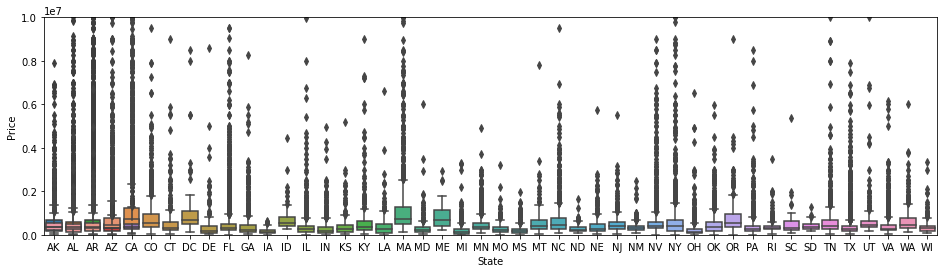

In [176]:
plt.figure(figsize=(16,4))
sns.boxplot(data = house_df, x = 'Type' , y = 'Price')
ax = sns.boxplot(data = house_df, x = 'State' , y = 'Price')
ax.set_ylim(0,10000000)

In [191]:
# from visualization we realize the data has many outliers
# Creating a function to remove outliers
def create_val(a):
    df = house_df[house_df['State'] == a]
    avg = df['Price'].mean()
    std = df['Price'].std()
    z = (house_df.Price - avg) / std 
    return z
# absolute value of Z < 3


house_df['z_score'] = house_df.State.apply(create_val)

In [194]:
house_df.head(20)


,Bedrooms,Bathrooms,Size,Type,Price,City,State,ZipCode,perSqFt,Region,z_score
0,8.00,4.00,3264.00,Multifamily,459900.00,Anchorage,AK,99501,140.90,West,0.03
1,2.00,1.00,778.00,Condo,89900.00,Anchorage,AK,99508,115.55,West,0.03
2,8.00,4.00,3880.00,Multifamily,590000.00,Eagle River,AK,99577,152.06,West,0.03
3,6.00,5.00,4640.00,House,589900.00,Chugiak,AK,99567,127.13,West,0.03
4,2.00,2.00,1152.00,Condo,184000.00,Anchorage,AK,99502,159.72,West,0.03
5,3.00,2.00,1648.00,House,214900.00,Eagle River,AK,99577,130.40,West,0.03
6,3.00,1.00,1040.00,House,205000.00,Anchorage,AK,99503,197.12,West,0.03
7,2.00,2.00,1024.00,Condo,183000.00,Anchorage,AK,99515,178.71,West,0.03
8,6.00,5.00,2984.00,Multifamily,334500.00,Anchorage,AK,99507,112.10,West,0.03
9,3.00,3.00,3778.00,House,1299000.00,Anchorage,AK,99516,343.83,West,0.03


### Data Visualization

#### Pivot Tables

In [172]:
# Pivot table by region
pd.set_option('display.float_format', '{:.2f}'.format)
pd.pivot_table(house_df, values=['perSqFt','Size','Bedrooms','Bathrooms','Price'], index=['Region'])

,Bathrooms,Bedrooms,Price,Size,perSqFt
Region,,,,,
MidWest,2.32,3.24,336447.39,2107.67,144.61
North,2.56,3.65,1032088.99,2420.80,565.54
South,2.76,3.37,485822.47,2319.96,196.88
West,2.91,3.61,1134146.42,2468.04,444.10


In [168]:
# Piviot Tabel, setting format display to float with 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
pivot_state = pd.pivot_table(house_df, values=['perSqFt','Size','Bedrooms','Bathrooms','Price'], index=['State'])
pivot_state

,Bathrooms,Bedrooms,Price,Size,perSqFt
State,,,,,
AK,3.31,4.94,447688.19,2728.05,176.94
AL,2.77,3.43,372348.44,2526.98,136.81
AR,3.21,3.81,507569.58,3072.85,142.81
AZ,2.91,3.50,864523.98,2621.48,511.35
CA,2.86,3.57,1459234.62,2316.31,528.38
CO,2.88,3.36,912330.16,2450.87,348.04
CT,2.84,4.22,570666.59,2705.55,212.42
DC,2.94,3.05,1464815.72,2107.08,574.93
DE,2.71,3.53,568675.31,2786.49,147.46


#### Cleaned and Organized more Data

In [169]:
#Converting pivot into DF and reset index
pivot_df =pd.DataFrame(pivot_state)
pivot_df = pivot_df.reset_index()

# create function to insert fullState name for merge
def insert_fullState(a):
    a = state_dict[a]
    return a
# insert both fullState and Region
pivot_df['fullState'] = pivot_df.State.apply(insert_fullState)
pivot_df['Region'] = pivot_df.State.apply(find_region)
pivot_df



,State,Bathrooms,Bedrooms,Price,Size,perSqFt,fullState,Region
0,AK,3.31,4.94,447688.19,2728.05,176.94,Alaska,West
1,AL,2.77,3.43,372348.44,2526.98,136.81,Alabama,South
2,AR,3.21,3.81,507569.58,3072.85,142.81,Arkansas,South
3,AZ,2.91,3.50,864523.98,2621.48,511.35,Arizona,West
4,CA,2.86,3.57,1459234.62,2316.31,528.38,California,West
5,CO,2.88,3.36,912330.16,2450.87,348.04,Colorado,West
6,CT,2.84,4.22,570666.59,2705.55,212.42,Connecticut,North
7,DC,2.94,3.05,1464815.72,2107.08,574.93,District of Columbia,North
8,DE,2.71,3.53,568675.31,2786.49,147.46,Delaware,South
9,FL,2.53,3.07,573222.09,1858.28,252.61,Florida,South


In [171]:
# Creating state_df; now we have both state_df and house_df
state_df = merged_df.merge(pivot_df, how = 'inner', on = 'fullState')
state_df

,fullState,GDP,Spending,Population,Income,State,Bathrooms,Bedrooms,Price,Size,perSqFt,Region
0,Alabama,196906.10,176479.80,4934193,228748.80,AL,2.77,3.43,372348.44,2526.98,136.81,South
1,Alaska,50161.00,35635.70,724357,46430.30,AK,3.31,4.94,447688.19,2728.05,176.94,West
2,Arizona,320550.60,287090.10,7520103,368458.60,AZ,2.91,3.50,864523.98,2621.48,511.35,West
3,Arkansas,114943.50,104488.80,3033946,143147.90,AR,3.21,3.81,507569.58,3072.85,142.81,South
4,California,2663665.90,1835980.60,39613493,2763312.00,CA,2.86,3.57,1459234.62,2316.31,528.38,West
5,Colorado,346011.30,270883.00,5893634,370392.10,CO,2.88,3.36,912330.16,2450.87,348.04,West
6,Connecticut,235888.60,179405.90,3552821,279612.40,CT,2.84,4.22,570666.59,2705.55,212.42,North
7,Delaware,62056.20,44834.50,990334,55357.40,DE,2.71,3.53,568675.31,2786.49,147.46,South
8,District of Columbia,122342.10,46453.60,714153,61706.10,DC,2.94,3.05,1464815.72,2107.08,574.93,North
9,Florida,944000.80,947905.90,21944577,1209995.90,FL,2.53,3.07,573222.09,1858.28,252.61,South


#### Visualizations

[(0.0, 14067.9)]

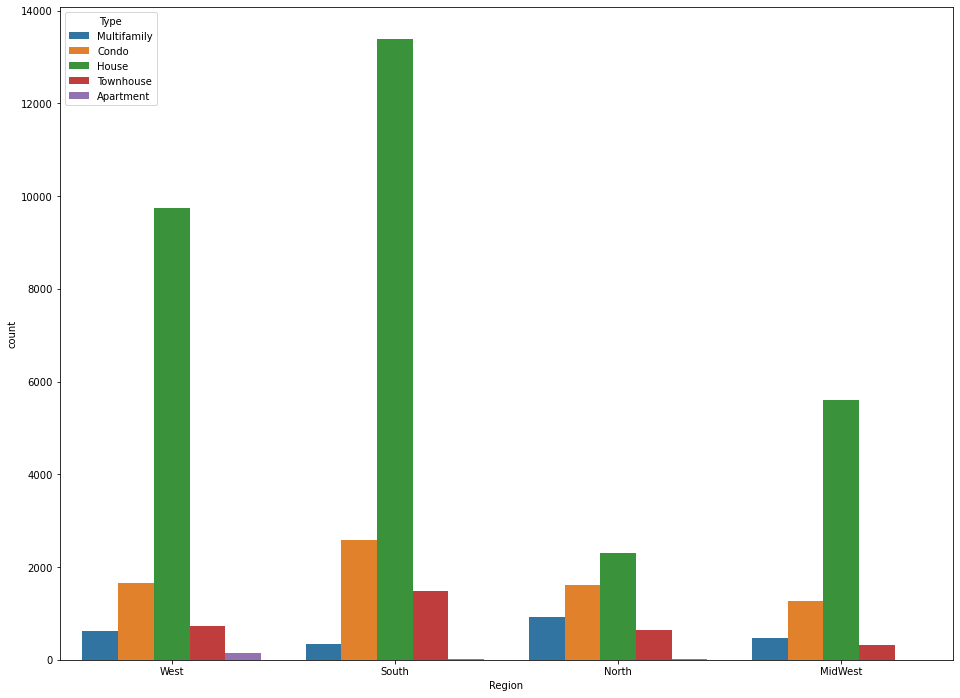

In [ ]:
plt.figure(figsize=(16,12))
g=sns.countplot(x='Region',data=house_df,hue='Type')
g.set(ylim=(0, None))

(0.0, 10000000.0)

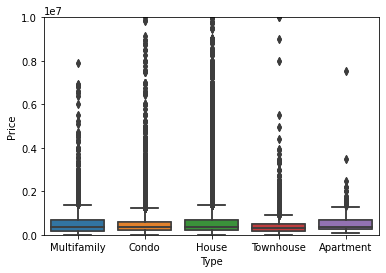

In [ ]:
#Created a visulization of average price of properties within data



In [ ]:
'''
NOT WORKING CORRECTLY


data = dict(type = 'choropleth',colorscale='Portland',locations=df3['State'],locationmode='USA-states', z=df3['Price'],text=df3['Price'], colorbar={'title':'perSqFt'})
choromap = go.Figure(data = [data],layout = dict(geo = {'scope':'usa'}))

iplot(choromap,validate=False)
'''

In [ ]:
# for GeoPandas later use
# df2 = df2[df2['ZipCode'].between(10000,99999,inclusive='both')]

### Conclusion

In [ ]:
'''



'''

### References

In [ ]:
'''
References

Data of:    Housing Prices
https://www.kaggle.com/dataranch/zillow-1

Data of:    Population
https://worldpopulationreview.com/states

Data of:    GDP, Income, Spending 
https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1&acrdn=1#reqid=70&step=1&isuri=1&acrdn=1


'''